In [1]:
import numpy as np
import pandas as pd
import AgentClass
import const
import random
import networkx as nx
from config import num_agents,number_of_bits
from scipy import stats
from collections import defaultdict
import json
import utilities

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib
import seaborn as sns

import pymc3 as pm


In [46]:
def get_tau_distr():
    lower = 0
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = 1000

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

In [47]:
def create_environment():
    list_agents = []
    tau_distr = get_tau_distr()

    for i in range(num_agents):
        in_state = np.random.randint(2, size=number_of_bits).tolist()
        a = AgentClass.Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.newman_watts_strogatz_graph(num_agents, 5, 0.5, seed= 0)
#    nx.draw(G, with_labels=True, font_weight='bold') # to draw agents
    df = nx.to_pandas_adjacency(G, dtype=int)

    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}

    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])

    return list_agents

In [48]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name,
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [49]:
def run_simulation(alpha, const:const.Constants, list_agents, end_time):
    d = []
    generations = 0
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            agt.update_knowledge(alpha, const.coh_transition_matrix, const.bit_matrix)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Name':agt.name,
                   'Agent_Dissonance':np.array(agt.dissonance_lst),
                   'Time':t,
                   'probs':agt.soc_probs,
                   'Current_Knowledge_State':agt.knowledge_state,
                   'Current': utilities.bool2int(agt.knowledge_state),
                   'Next': utilities.bool2int(agt.next_state),
                   'Next_Knowledge_State':agt.next_state}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1
#         if generations%10 == 0:
#             print("alpha = {}; {} generations".format(alpha,generations))

    return pd.DataFrame(d)

In [50]:
 # constants intialization
end_simulation_time = 100
alphas = [0.7]
exp_times = 1

# first create environment
agents_list = create_environment()

# get network of the agents
agent_network_df = get_network_df(agents_list)

results = {}

# for saving
agent_network_df.to_json('test_network.json',orient='records', lines=True)

for i in range(exp_times):

    random.seed(i)
    results['seed'] = i

    constants = const.Constants()

    results['coherence_matrix'] = coherence_matrix = constants.get_coh_tx_matrix().tolist()


    results['alphas'] = defaultdict(list)

    # run simulation
    for alpha in alphas:
#            record_df = pd.DataFrame({'Agent_Name':[], 'Agent_Dissonance':[], 'Time':[], 'Current_Knowledge_State':[], 'Next_Knowledge_State':[]})

        record_df = run_simulation(alpha, constants, agents_list, end_simulation_time)
#         results['alphas'][alpha].append(record_df.to_json(orient='records', lines=True))

Woking with bits to flip: 0 - 4


In [51]:
knowledge_states = record_df['Current_Knowledge_State'].tolist()
int_knowledge_vals = np.array([utilities.bool2int(i) for i in knowledge_states])
K = np.zeros((len(int_knowledge_vals), 2**number_of_bits))
K[np.arange(len(int_knowledge_vals)), int_knowledge_vals] = 1


next_states = record_df['Next_Knowledge_State'].tolist()
int_nextstates_vals = np.array([utilities.bool2int(i) for i in next_states])
N = np.zeros((len(int_nextstates_vals), 2**number_of_bits))
N[np.arange(len(int_nextstates_vals)), int_nextstates_vals] = 1

soc_probs = record_df['probs'].tolist()


In [8]:
pd.DataFrame(coherence_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.046033,0.054227,0.030705,0.032208,0.223309,0.097468,0.048820,0.003503,0.000000,0.093137,0.263270,0.034892,0.006184,0.007707,0.042345,0.016192
1,0.047623,0.001110,0.077476,0.265202,0.033773,0.100289,0.091319,0.016896,0.028286,0.068266,0.016749,0.087637,0.049248,0.012079,0.088490,0.015557
2,0.096670,0.102881,0.229255,0.230130,0.073571,0.015801,0.016779,0.018433,0.002801,0.043533,0.038091,0.044787,0.018478,0.006265,0.016282,0.046243
3,0.058886,0.070261,0.012974,0.045486,0.011325,0.028818,0.062900,0.091143,0.118446,0.118775,0.068109,0.181243,0.026620,0.000000,0.055830,0.049185
4,0.008631,0.058703,0.059486,0.075186,0.175310,0.038277,0.122450,0.006139,0.090821,0.009670,0.010666,0.007787,0.122931,0.034648,0.086248,0.093047
5,0.237184,0.000000,0.074793,0.039594,0.091982,0.021567,0.069096,0.008498,0.047060,0.168196,0.041434,0.074824,0.026314,0.009833,0.077075,0.012549
6,0.004187,0.029999,0.038971,0.001619,0.102181,0.066324,0.097264,0.001328,0.031057,0.077675,0.087786,0.025286,0.015638,0.104724,0.292964,0.022998
7,0.044337,0.012664,0.027219,0.018244,0.134622,0.044223,0.081115,0.051293,0.008261,0.025363,0.094569,0.160774,0.049260,0.232829,0.015227,0.000000
8,0.054528,0.014425,0.002562,0.213124,0.018369,0.011257,0.154366,0.048422,0.015181,0.046628,0.019044,0.226497,0.032209,0.020679,0.089047,0.033662
9,0.005137,0.252077,0.158157,0.022507,0.029780,0.080844,0.093318,0.004080,0.068614,0.031203,0.128843,0.017100,0.002729,0.016439,0.070990,0.018183


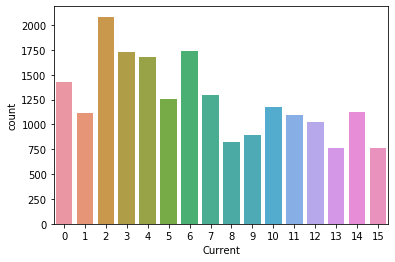

In [52]:
sns.countplot(x='Current', data=record_df)

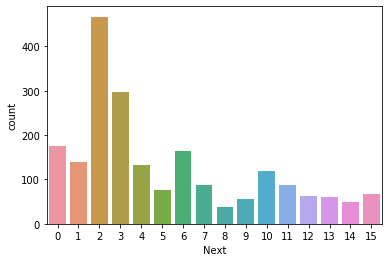

In [53]:
sel_state = 2
data = record_df[record_df['Current']==sel_state]
sns.countplot(x='Next', data=data)

In [56]:
soc_probs = np.asarray(data['probs'].tolist())
y = np.asarray(data['Next'].tolist())
alpha = 0.7
k = 16
#Try 1-hot encoding
y_hot = np.eye(k)[y]

In [57]:
with pm.Model() as model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a, shape=k)
    tmp = alpha*soc_probs + (1-alpha)*theta
    results = pm.Multinomial("results", n=1, p=tmp, observed=y_hot, shape=k)

/Users/jintrone/Dropbox/@CONTRACTS/2019/NSF/VACCINES/DEV/agents_simulations/venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [58]:
with model:
     trace = pm.sample(draws=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:17<00:00, 344.80draws/s]


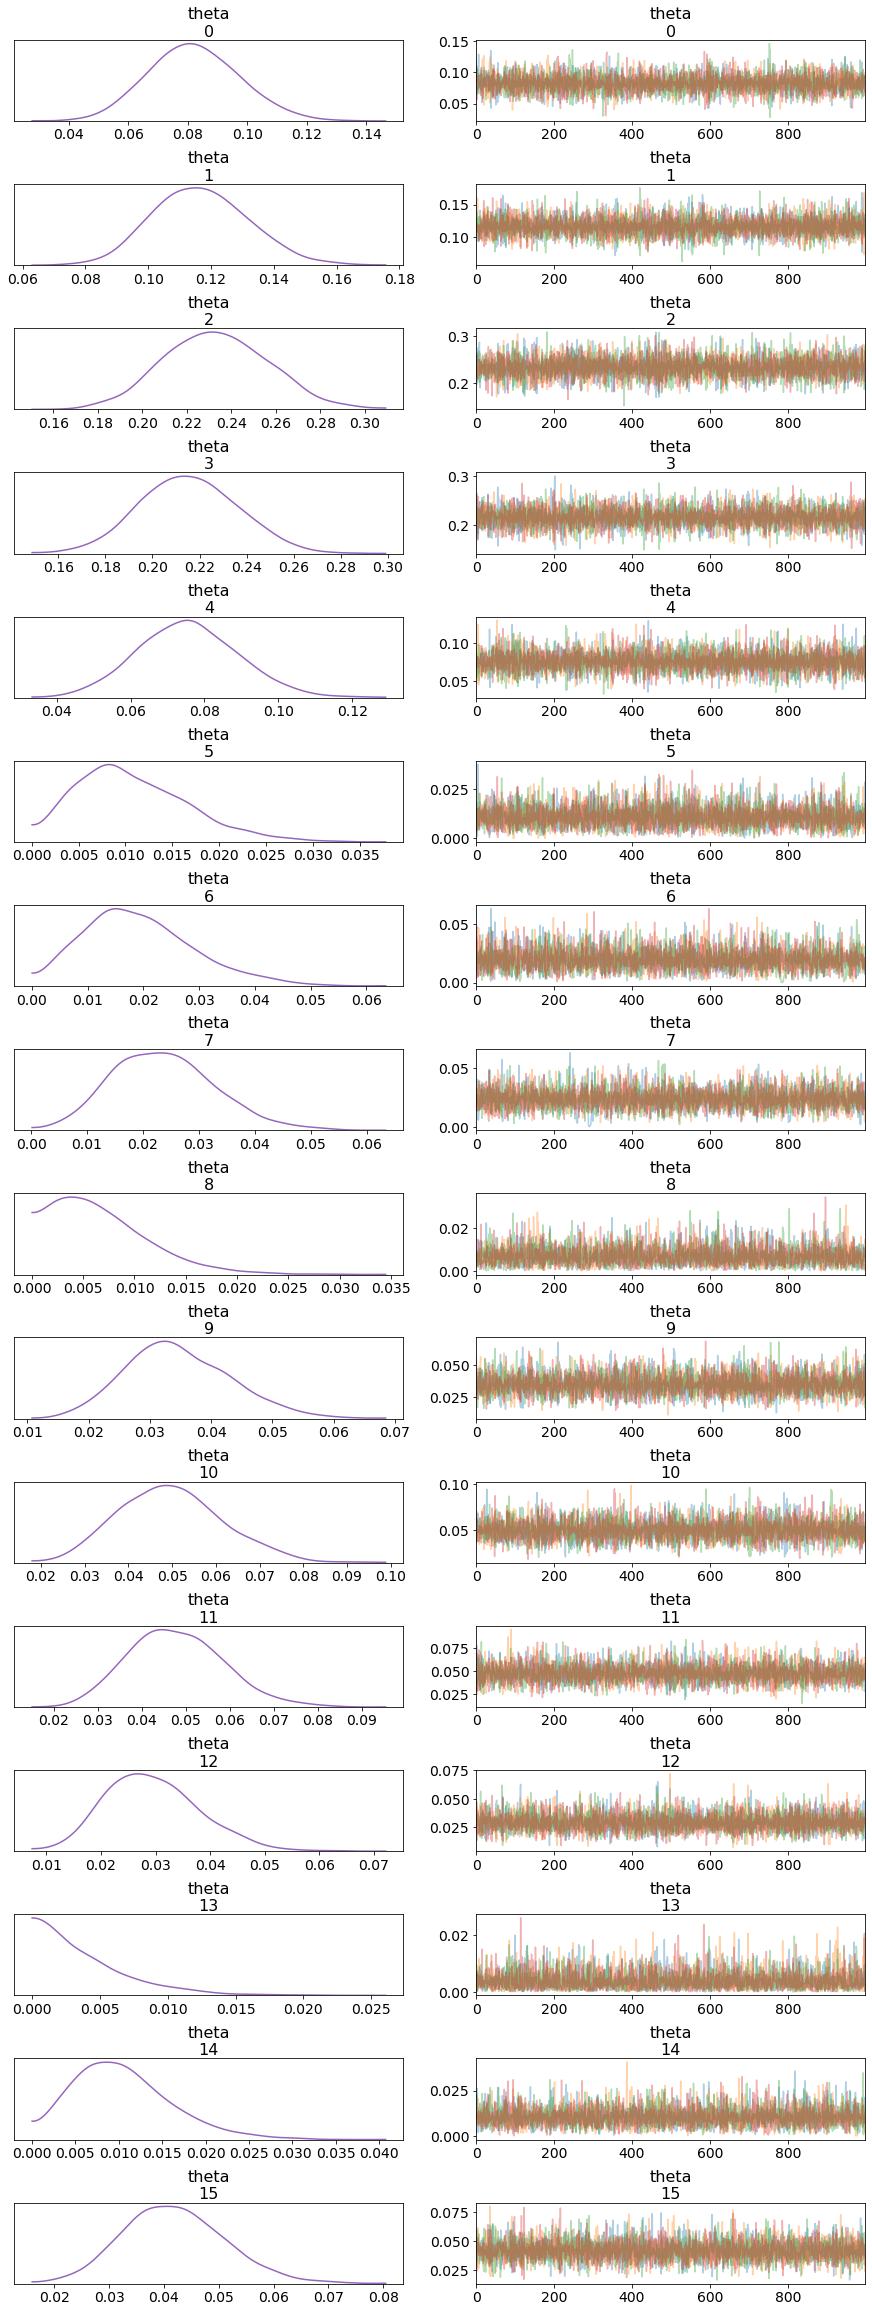

In [59]:
with model:
    pm.traceplot(trace, combined=True)

In [60]:
pm.summary(trace).round(4)[['mean']].T

,theta__0,theta__1,theta__2,theta__3,theta__4,theta__5,theta__6,theta__7,theta__8,theta__9,theta__10,theta__11,theta__12,theta__13,theta__14,theta__15
mean,0.0819,0.1166,0.233,0.2152,0.0754,0.0108,0.0193,0.0236,0.0068,0.0346,0.0496,0.0477,0.0294,0.0039,0.0104,0.0418


In [61]:
pd.DataFrame(pd.DataFrame(coherence_matrix).iloc[sel_state]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2,0.09667,0.102881,0.229255,0.23013,0.073571,0.015801,0.016779,0.018433,0.002801,0.043533,0.038091,0.044787,0.018478,0.006265,0.016282,0.046243


/Users/jintrone/Dropbox/@CONTRACTS/2019/NSF/VACCINES/DEV/agents_simulations/venv/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


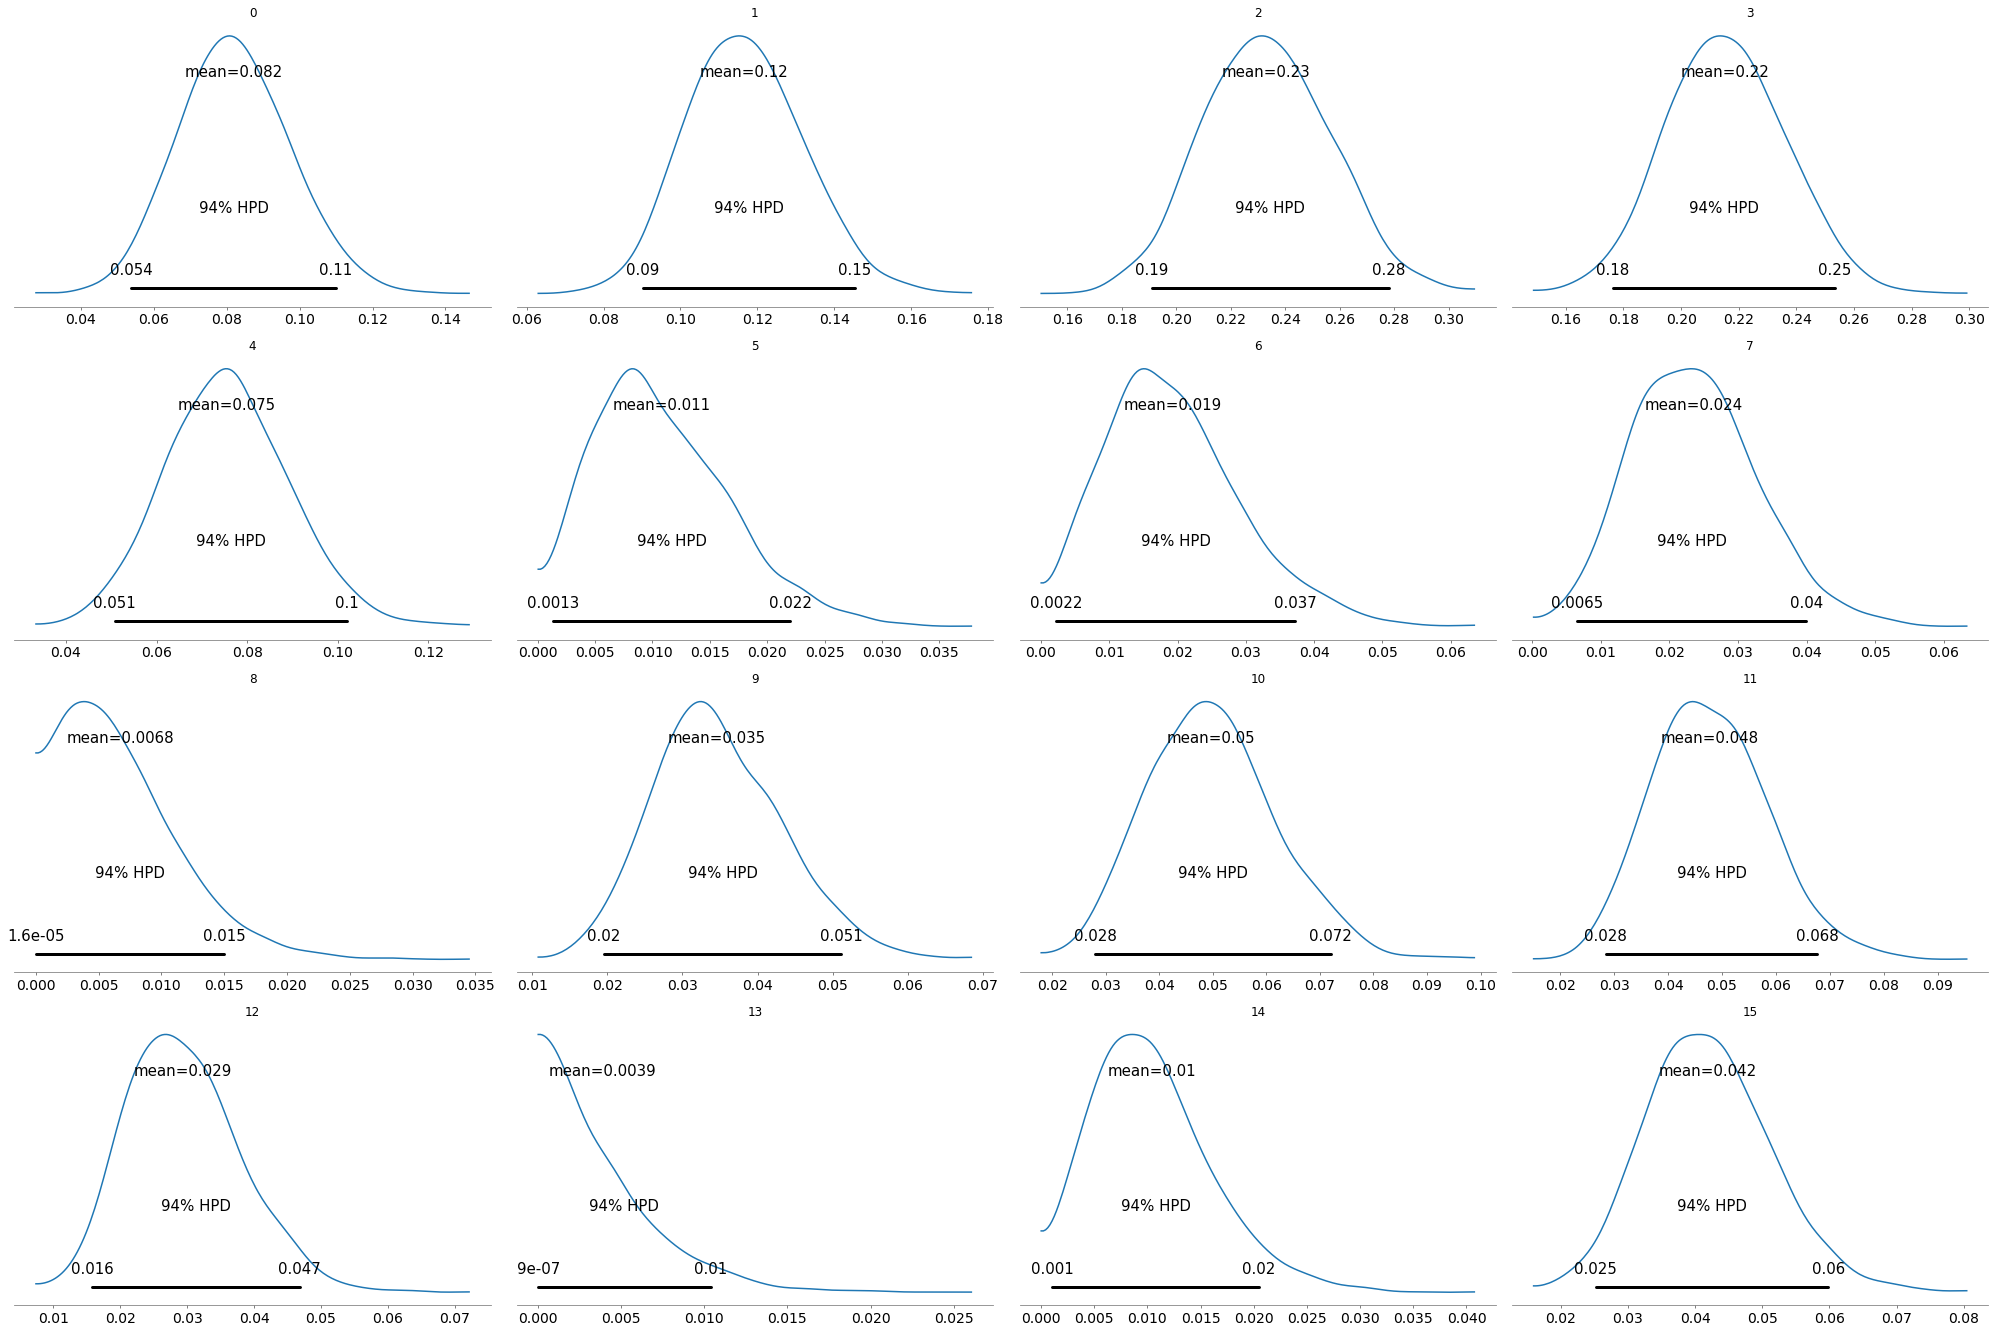

In [62]:
axes = pm.plot_posterior(trace, 
                          varnames=["theta"])
for i, ax in enumerate(axes):
    ax.set_title(f"{i}")